# Drifter L2 different filter analysis
- implement each filter for a ndarray
- plot PSD of each filter : gaussian, wavelet, low pass complex

In [1]:
import os
from glob import glob

import cartopy.geodesic as geod
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic

import scipy
import scipy.signal

import numpy as np
import xarray as xr
import pandas as pd

import jax
import jax.numpy as jnp
import jaxparrow as jpw

import clouddrift as cd


%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

drifters_directory = '/home/bouxdecl/Documents/data/DRIFTERS'

path_save_plot = './save_plots/save_plots_2024-06-25_DrifterL2_filter_variance_analysis/'

## Data selection

#### drifters data

In [2]:
L2_dir = drifters_directory + '/L2'
os.listdir(L2_dir)[:5]

['L2_svp_scripps_10min_lowess_10min_v0.nc',
 'L2_carthe_uwa_5min_variational_10min_v0.nc',
 'L2_svp_ogs_1h_variational_10min_v0.nc',
 'L2_svp_bcg_10min_variational_10min_v0.nc',
 'L2_svp_scripps_10min_lowess_30min_v0.nc']

filename convention : L1_type_source_aaaammjj_hhmmss_sampling.format

In [3]:
def file_selection_mediterranean(files):
    # only mediterranean (not containing 'uwa') 

    selected_files = []
    for file in files:
         if not file.count("uwa"):
            selected_files.append(file)
    return selected_files

def file_selection_by_method(files, method: str):
    # files from one interpolation method: 'variationnal' or 'lowess'

    selected_files = []
    for file in files:
         if file.count(method):
            selected_files.append(file)
    return selected_files

def file_selection_by_sampling(files, sampling: str):
    # files from one smooth L2 sampling: '10min', '30min', '1h' at the end of the file_name

    selected_files = []
    for file in files:
         if file[-11:].count(sampling):
            selected_files.append(file)
    return selected_files


In [4]:
mediterranea_files = file_selection_mediterranean(os.listdir(L2_dir))

file_lowess_10min = file_selection_by_method(mediterranea_files, "lowess")
file_lowess_10min = file_selection_by_sampling(file_lowess_10min, "10min")

file_lowess_30min = file_selection_by_method(mediterranea_files, "lowess")
file_lowess_30min = file_selection_by_sampling(file_lowess_30min, "30min")

file_lowess_1h = file_selection_by_method(mediterranea_files, "lowess")
file_lowess_1h = file_selection_by_sampling(file_lowess_1h, "1h")

#### fields data functions

In [5]:
def _add_one_Tgrid_velocity(ds, u, axis, padding, replace=True):
    u_t = jpw.tools.operators.interpolation(jnp.copy(ds[u].values), axis=axis, padding=padding)
    if replace:
        ds[u] = ds[u].copy(data=u_t)
    else:
        ds[str(u)+'_t'] = ds[u].copy(data=u_t)
    return ds

def add_Tgrid_velocities(ds):

    ds = _add_one_Tgrid_velocity(ds, 'u_geos', axis=1, padding='left', replace=True)
    ds = _add_one_Tgrid_velocity(ds, 'v_geos', axis=0, padding='left', replace=True)

    ds = _add_one_Tgrid_velocity(ds, 'u_var', axis=1, padding='left', replace=True)
    ds = _add_one_Tgrid_velocity(ds, 'v_var', axis=0, padding='left', replace=True)

    return ds


def interp_velocity_fields(ds, u: str, v: str, time_vec, lat_vec, lon_vec):
    # x,y mapping on latitude, longitude is a regular grid
    new_y = np.interp(lat_vec, ds.latitude[:, 0], ds.y)
    new_x = np.interp(lon_vec, ds.longitude[0, :], ds.x)

    # interpolation on points of the trajectory
    ds_interp = ds.interp(time = time_vec, x=new_x, y=new_y)
    
    # extract velocities
    u_interp   = np.array([ds_interp[u][i, i, i] for i in range(time_vec.shape[0]) ])
    v_interp   = np.array([ds_interp[v][i, i, i] for i in range(time_vec.shape[0]) ])

    return u_interp, v_interp




#### Comparison functions

In [6]:

def get_velocities_array(ds_traj, u_traj_name, v_traj_name, lat_traj_name, lon_traj_name, vector_spacing):
    time_vec = ds_traj.time.values[::vector_spacing]
    lat_vec  = ds_traj[lat_traj_name].values[::vector_spacing]
    lon_vec  = ds_traj[lon_traj_name].values[::vector_spacing]
    u_vec    = ds_traj[u_traj_name].values[::vector_spacing]
    v_vec    = ds_traj[v_traj_name].values[::vector_spacing]
    return time_vec, lat_vec, lon_vec, u_vec, v_vec


def comparison_velocities_drifters_fields(ds_field: xr.Dataset, u_field_name: str, v_field_name: str, 
                                          ds_traj:  xr.Dataset, u_traj_name:  str,  v_traj_name: str, lat_traj_name: str, lon_traj_name: str,
                                        
                                          vector_spacing = 50, scale=1e-5, width=3e-3, plot=False, save_name=None):


    # get velocities vectors from difters
    time_vec, lat_vec, lon_vec, u_vec, v_vec = get_velocities_array(ds_traj, u_traj_name, v_traj_name, lat_traj_name, lon_traj_name, vector_spacing)

    # get interpolated field velocities at these points
    u_field, v_field = interp_velocity_fields(ds_field, u_field_name, v_field_name, time_vec, lat_vec, lon_vec)

    if plot:
        # Plot the trajectory with the velocity vectors AND fields vectors
        fig = plt.figure(tight_layout=True, figsize=(8, 8))
        crs = ccrs.PlateCarree()
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
        gl = ax.gridlines(draw_labels=True,)
        ax.add_feature(cfeature.LAND,)

        # drifter trajectory
        ax.plot(ds_traj[lon_traj_name], ds_traj[lat_traj_name],transform=crs, label='drifter trajectory')

        # drifters velocity
        ax.quiver(lon_vec, lat_vec, u_vec, v_vec, 
                  color='black', angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), label = 'drifters velocities')
        
        # field velocity
        ax.quiver(lon_vec, lat_vec, u_field, v_field,
                  color='r', angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), label='field velocities')


        plot_marge = 0.02
        ax.set_extent([np.nanmin(lon_vec) - plot_marge, np.nanmax(lon_vec) + plot_marge, np.nanmin(lat_vec) - plot_marge, np.nanmax(lat_vec) + plot_marge], crs=ccrs.PlateCarree())

        ax.legend()

        if save_name:
            ax.set_title(save_name)
            save_name = save_name + '.png'
            plt.savefig(os.path.join(path_save_plot, save_name), bbox_inches='tight', dpi = 300)

    return time_vec, lat_vec, lon_vec, u_vec, v_vec, u_field, v_field




def plot_traj_vectors(traj_lon, traj_lat, name_list, u_list, v_list, lon_vec_list, lat_vec_list,
                      scale=1e-5, width=3e-3, save_name=None):
    
    # Plot the trajectory with the velocity vectors AND fields vectors
    fig = plt.figure(tight_layout=True, figsize=(8, 8))
    crs = ccrs.PlateCarree()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
    gl = ax.gridlines(draw_labels=True,)
    ax.add_feature(cfeature.LAND,)

    # drifter trajectory
    ax.plot(traj_lon, traj_lat, transform=crs, label='drifter trajectory')

    # plot vectors for each element in name_list
    for name, u, v, lon, lat in zip(name_list, u_list, v_list, lon_vec_list, lat_vec_list):
        ax.quiver(lon, lat, u, v, 
                  angles='xy', scale_units='xy', scale=scale, width=width, transform=ccrs.PlateCarree(), label = name)

    ax.legend()

    if save_name:
        ax.set_title(save_name)
        save_name = save_name + '.png'
        plt.savefig(os.path.join(path_save_plot, save_name), bbox_inches='tight', dpi = 300)

In [7]:
# MIOST field data

path = '/home/bouxdecl/Documents/my_python/MIOST/data_RESULTS/'
ds_nadir = xr.open_dataset(os.path.join(path, 'results_MIOST_allnadirs-alg_GOOD.nc'))
ds_swot = xr.open_dataset(os.path.join(path, 'results_MIOST_allnadirs-alg_and_SWOT_GOOD.nc'))

# add t-grid values for velocities

ds_nadir = add_Tgrid_velocities(ds_nadir)
ds_swot  = add_Tgrid_velocities(ds_swot)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## One trajectory filtering

In [8]:
# load one file
file = 'L2_svp_ogs_10min_lowess_10min_v0.nc'
file = file_lowess_10min[8]
id_idx = 0

ds = xr.open_dataset(os.path.join(L2_dir, file))
#remove nan in the beginning and select only one drifter
ds_traj = ds.dropna(dim='time', how='any', subset=['u']).isel(id=id_idx)#.isel(time=slice(1000, 2000))

#time resolution in seconds
dt = float(ds_traj.time[1] - ds_traj.time[0])*1e-9
vector_spacing = 50

#### PSD plot

In [9]:
def welch(sig_list, name_list, dt, nfenetre = None, save=True):

    if nfenetre is None:
        nfenetre = len(sig_list[0]) //3

    fig, ax = plt.subplots()

    results = []
    for sig, lb in zip(sig_list, name_list):
        frequencies, psd = scipy.signal.welch(sig, fs=1/dt, nperseg = nfenetre, noverlap=nfenetre//4)
        ax.semilogy(frequencies, psd, label=lb)
        results.append((frequencies, psd))

    ax.axvline(-1/(19*3600), c='black', ls='--', label='19h (99% filtering)')
    ax.axvline(-1/(36*3600), c='grey', ls='--', label='36h (1% filtering)')

    xlim = 10**(-4)
    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(1/1500, 5000)

    ax.set_title('PSD of the complex velocity (Welch\'s Method)')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('PSD (V^2/Hz)')
    ax.grid()
    ax.legend()

    # Set the x-axis to display in powers of ten
    formatter = matplotlib.ticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    plt.show()

    if save:
        save_name = 'PSD'+ name_list[1] + '.png'
        plt.savefig(os.path.join(path_save_plot, save_name), bbox_inches='tight', dpi = 300)

    return results

/home/bouxdecl/miniconda3/envs/gdp6h_duacs_jaxparrow/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:462: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,


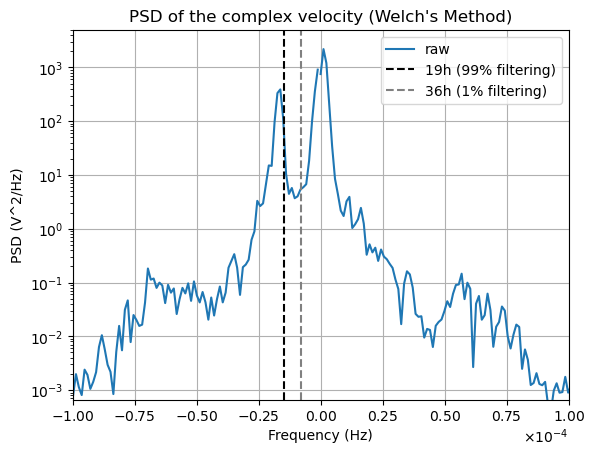

In [10]:
sig_raw = ds_traj['u'] + 1j* ds_traj['v']
_ = welch([sig_raw], ['raw'], dt, save=False)

### filtering

#### wavelet

In [11]:

def wavelet_filter(x, y, lat, dt, wavelet_width_fration=0.5, plot_wavelet=False):
    '''
    apply wavelet transform and return the filtered data without the wavelet component
    '''
    
    # --- defines Morlet wavelet function (for each point because inertial oscillation are latitude dependant)
    
    # central frequency : coriolis frequency
    tau_lat = 12.93447/np.sin(lat/180 * np.pi) *3600 #s
    fc_lat  = 1/tau_lat

    # width and convolution window
    wavelet_width  = tau_lat * wavelet_width_fration
    wavelet_window = float(wavelet_width[0]) * 4   #wavelet window

    # defines wavelet and normalize
    tt      = np.arange(-wavelet_window, wavelet_window + dt, dt)
    wavelet = (np.exp(-1j*2*np.pi*np.outer(fc_lat,tt))*np.exp(-np.outer(1/2*wavelet_width**-2,tt**2)))

    row_sums = np.sum(np.abs(wavelet), axis=1)[:, np.newaxis] + 1e-10
    wavelet = wavelet / row_sums 

    n_points, n_wavelet_times = wavelet.shape

    if plot_wavelet:
        plt.plot(tt/float(tau_lat[0]), wavelet[0])


    # --- pass in local complex plane and padding
    X = x + 1j* y

    padd_width = n_wavelet_times -1   #half the number of points of the wavelet
    X_padded = np.pad(X, padd_width, mode='symmetric')
    
    #convolve
    X_oscil = X_padded*0.+np.nan
    for point in range(n_points):
        X_oscil = np.convolve(X_padded[:], wavelet[point, :], 'same')

    #remove pad and get processed values
    X_oscil = X_oscil[padd_width:-padd_width]
    
    x_process = (X - X_oscil).real
    y_process = (X - X_oscil).imag

    #remove offset
    x_process -= float((x_process - x).mean())
    y_process -= float((y_process - y).mean())

    return x_process, y_process



def apply_wavelet_filter(ds_traj, wavelet_width_fration = 0.5, plot_wavelet=False):

    traj = ds_traj.copy()  

    u = traj.u
    v = traj.v
    lon = traj.lon
    lat = traj.lat
    dt = float(traj.time[1] - traj.time[0])*1e-9  #s

    # --- data preprocessing

    u_process, v_process     = wavelet_filter(u  , v  , lat, dt, wavelet_width_fration=wavelet_width_fration, plot_wavelet=plot_wavelet)
    lon_process, lat_process = wavelet_filter(lon, lat, lat, dt, wavelet_width_fration=wavelet_width_fration)

    # --- replace old data by filtered data
    traj['u']   = traj.u.copy(data= u_process)
    traj['v']   = traj.v.copy(data= v_process)
    traj['lon'] = traj.lon.copy(data= lon_process)
    traj['lat'] = traj.lat.copy(data= lat_process)

    return traj


#### gaussian filter

In [72]:
def gaussian_filter(x, dt=dt, gaussian_width=24*3600, plot=False):

    # defines gaussian
    gaussian_window_width = 3*gaussian_width
    tt = np.arange(-gaussian_window_width, gaussian_window_width+dt, dt)
    
    gaussian = np.exp(- 0.5* (tt/(gaussian_width/2) )**2)
    gaussian = gaussian / np.sum(np.abs(gaussian))
    
    #padd and convolve
    padd = len(gaussian) //2 -1
    x_padded = np.pad(x, padd, mode='symmetric')
    
    if plot:
        plt.plot(tt/3600, gaussian)

    return np.convolve(x_padded, gaussian, 'same')[padd:-padd]

#### complex filter with scipy

In [13]:
def get_tau_oscil(lat):
    return 12.93447/np.sin(lat/180 * np.pi) *3600 #s

get_tau_oscil(37)/3600, get_tau_oscil(43)/3600

(21.492434556144524, 18.96554413828016)

In [14]:
#filter_width = get_tau_oscil(lat=43) *1.27
filter_width = 48*3600
order = 8

dt = float(ds_traj.time[1] - ds_traj.time[0])*1e-9


def low_pass_complex(signal, dt=dt, cutoff = 1/filter_width, order=order):

    # filter param
    fs = 1/dt
    nyq = 0.5* fs
    normalized_cutoff = cutoff / nyq

    b, a = scipy.signal.butter(order, normalized_cutoff, btype='low', analog=False)

    # low pass and remove padd
    filtered_signal = scipy.signal.filtfilt(b, a, signal)
    
    return filtered_signal

In [15]:
ds_traj_lowpass = ds_traj.copy()
U = (ds_traj.u + 1j* ds_traj.v) .values
print(U.mean())


#signal filtering
U_lowpass = low_pass_complex(U)

ds_traj_lowpass['u'] = ds_traj.u.copy(data= U_lowpass.real)
ds_traj_lowpass['v'] = ds_traj.u.copy(data= U_lowpass.imag)

sig_raw      = ds_traj['u'] + 1j* ds_traj['v']
sig_filtered = ds_traj_lowpass['u'] + 1j* ds_traj_lowpass['v']

(0.07300750540726418+0.0881324593650922j)


**Variance Analysis**:
- 1% variance filtering at T=36h
- 99% variance filtering at T=19h

- variance preserving normalization

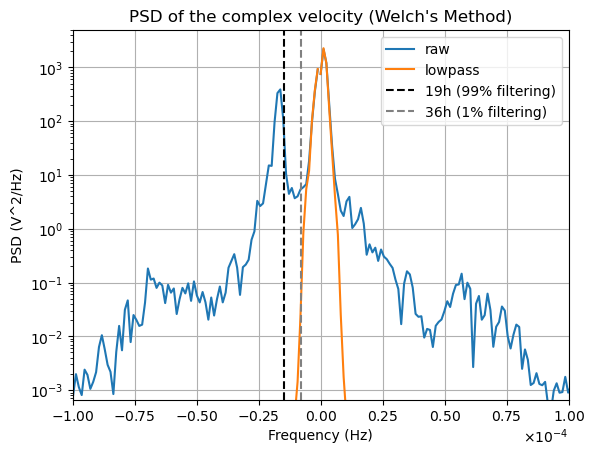

filtering at 19h: 1.342663576974474e-05
filtering at 24h: 2.9504822175618356e-05
filtering at 48h: 0.8040434047062145
filtering at 72h: 0.9394054694280658
filtering at 96h: 1.07101289911686
filtering at 120h: 1.065528004808856


In [87]:
freq_19 = 1/(19*3600)
freq_36 = 1/(36*3600)
freq_48 = 1/(48*3600)
freq_120 = 1/(120*3600)


#plot PSD
(freq0, psd0), (freq, psd) = welch([sig_raw, sig_filtered], ['raw', 'lowpass'], dt, save=False)

ord = np.argsort(freq) 

freq = freq[ord]
psd = psd[ord]
psd0 = psd0[ord]

filter_fraction = psd/psd0

# filtering at 19h
print('filtering at 19h:', np.interp(freq_19, freq, filter_fraction))
print('filtering at 24h:', np.interp(-1/(24*3600), freq, filter_fraction))
print('filtering at 48h:', np.interp(-1/(48*3600), freq, filter_fraction))
print('filtering at 72h:', np.interp(-1/(72*3600), freq, filter_fraction))
print('filtering at 96h:', np.interp(-1/(96*3600), freq, filter_fraction))
print('filtering at 120h:', np.interp(-1/(120*3600), freq, filter_fraction))

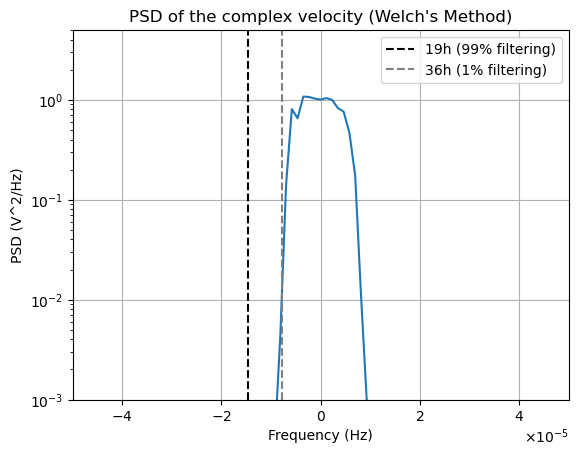

In [62]:
fig, ax = plt.subplots()

ax.semilogy(freq, filter_fraction)

ax.axvline(-1/(19*3600), c='black', ls='--', label='19h (99% filtering)')
ax.axvline(-1/(96*3600), c='grey', ls='--', label='96h (10% filtering)')

xlim = 0.5*10**(-4)
ax.set_xlim(-xlim, xlim)
ax.set_ylim(0.001, 5)

ax.set_title('PSD of the complex velocity (Welch\'s Method)')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD (V^2/Hz)')
ax.grid()
ax.legend()

# Set the x-axis to display in powers of ten
formatter = matplotlib.ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-1, 1))
ax.xaxis.set_major_formatter(formatter)

**Variance preserving**

In [63]:
df = freq[1] - freq[0]
scipy.integrate.simpson(psd, dx=df)

0.0072562768231451665

In [64]:
np.var(sig_raw - sig_raw.mean())

<xarray.DataArray ()>
array(0.01488808)
Coordinates:
    id       <U15 '300534064103890'

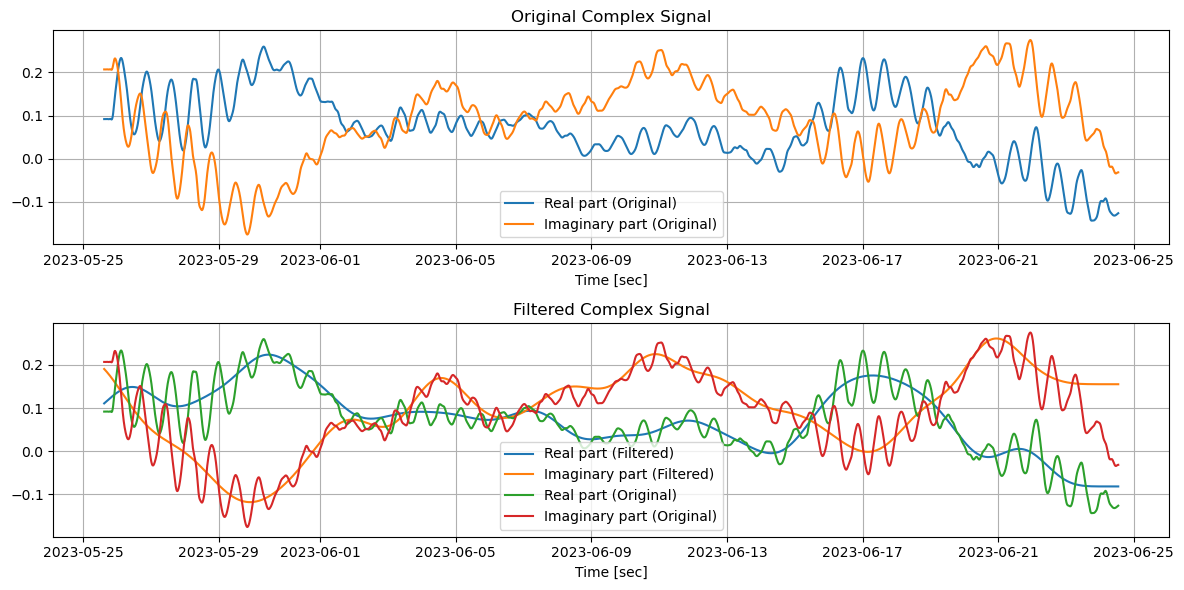

In [65]:
t = ds_traj.time

# Plot the original and filtered signals
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, np.real(sig_raw), label='Real part (Original)')
plt.plot(t, np.imag(sig_raw), label='Imaginary part (Original)')
plt.title('Original Complex Signal')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, np.real(sig_filtered), label='Real part (Filtered)')
plt.plot(t, np.imag(sig_filtered), label='Imaginary part (Filtered)')
plt.plot(t, np.real(sig_raw), label='Real part (Original)')
plt.plot(t, np.imag(sig_raw), label='Imaginary part (Original)')
plt.title('Filtered Complex Signal')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

## Gaussian filter analysis

In [143]:
file = file_lowess_10min[6]
id_idx = 7

ds = xr.open_dataset(os.path.join(L2_dir, file))
#remove nan in the beginning and select only one drifter
ds_traj = ds.dropna(dim='time', how='any', subset=['u']).isel(id=id_idx)#.isel(time=slice(1000, 2000))

#time resolution in seconds
dt = float(ds_traj.time[1] - ds_traj.time[0])*1e-9
vector_spacing = 50

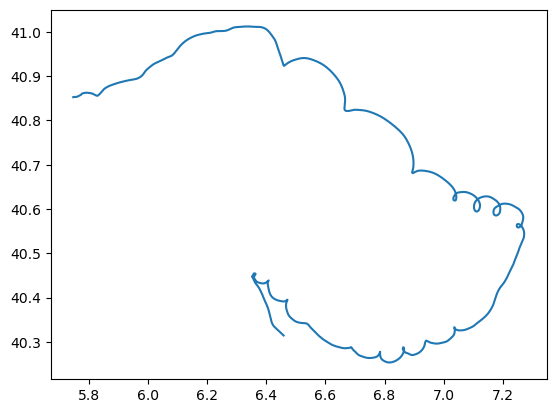

In [144]:
plt.plot(ds_traj.lon, ds_traj.lat)

In [145]:
def gaussian_filter(x, dt=dt, gaussian_width=12*3600):

    # defines gaussian
    gaussian_window_width = 3*gaussian_width
    tt = np.arange(-gaussian_window_width, gaussian_window_width+dt, dt)
    
    gaussian = np.exp(-0.5 * (tt/gaussian_width)**2)
    gaussian = gaussian / np.sum(np.abs(gaussian))
    
    #padd and convolve
    padd = len(gaussian) //2 -1
    x_padded = np.pad(x, padd, mode='symmetric')
    plt.plot(tt/3600, gaussian)
    return np.convolve(x_padded, gaussian, 'same')[padd:-padd]

In [146]:
tau = 12.93447/np.sin(40/180 * np.pi) *3600
tau*0.5/3600

10.061231583405599

/home/bouxdecl/miniconda3/envs/gdp6h_duacs_jaxparrow/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:462: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,


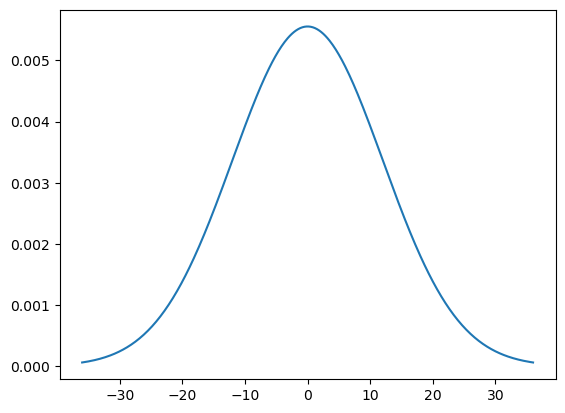

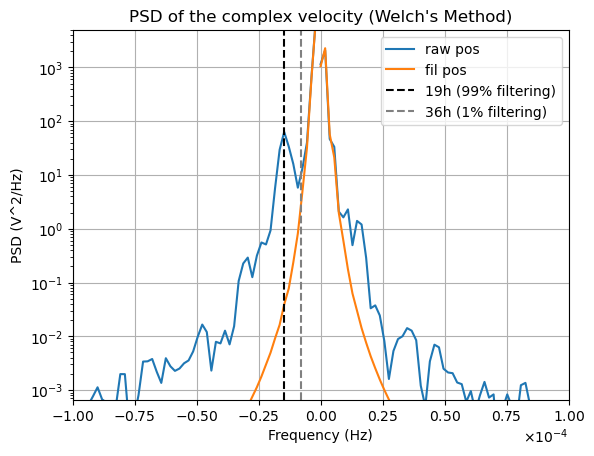

<Figure size 640x480 with 0 Axes>

In [147]:
sig = ds_traj.lon+1j*ds_traj.lat
sig -= np.mean(sig)
sig_filtered = gaussian_filter2(sig, gaussian_width=12*3600)

(freq0, psd0), (freq, psd) = welch([sig, sig_filtered], ['raw pos', 'fil pos'], dt=dt)

In [148]:

ord = np.argsort(freq) 

freq = freq[ord]
psd = psd[ord]
psd0 = psd0[ord]

filter_fraction = psd/psd0

# filtering at 19h
print('filtering at 19h:', np.interp(-1/(19*3600), freq, filter_fraction))
print('filtering at 24h:', np.interp(-1/(24*3600), freq, filter_fraction))
print('filtering at 48h:', np.interp(-1/(48*3600), freq, filter_fraction))
print('filtering at 72h:', np.interp(-1/(72*3600), freq, filter_fraction))
print('filtering at 96h:', np.interp(-1/(96*3600), freq, filter_fraction))
print('filtering at 120h:', np.interp(-1/(120*3600), freq, filter_fraction))

filtering at 19h: 0.0006740118809773594
filtering at 24h: 0.010944206202955484
filtering at 48h: 0.732911208591779
filtering at 72h: 0.9324206583160268
filtering at 96h: 0.9584485996596769
filtering at 120h: 0.9665309228883143


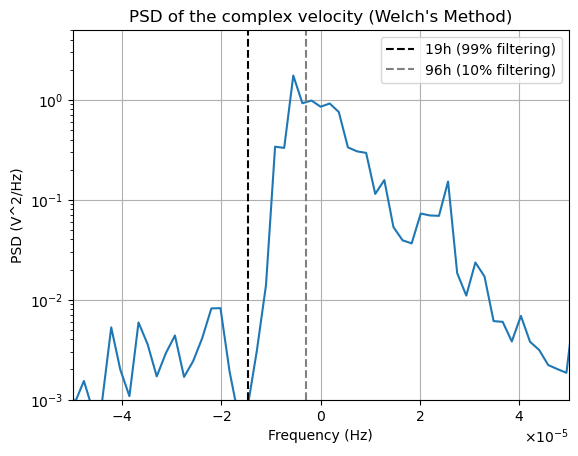

In [137]:
fig, ax = plt.subplots()

ax.semilogy(freq, filter_fraction)

ax.axvline(-1/(19*3600), c='black', ls='--', label='19h (99% filtering)')
ax.axvline(-1/(96*3600), c='grey', ls='--', label='96h (10% filtering)')

xlim = 0.5*10**(-4)
ax.set_xlim(-xlim, xlim)
ax.set_ylim(0.001, 5)

ax.set_title('PSD of the complex velocity (Welch\'s Method)')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD (V^2/Hz)')
ax.grid()
ax.legend()

# Set the x-axis to display in powers of ten
formatter = matplotlib.ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-1, 1))
ax.xaxis.set_major_formatter(formatter)

## trajectory scheme reconstuction
- use the process LOWESS used to find the L2 velocities in order to reconstruct the filtered position from the filtered velocity